# Net Surgery

Caffe networks can be transformed to your particular needs by editing the model parameters. The data, diffs, and parameters of a net are all exposed in pycaffe.

Roll up your sleeves for net surgery with pycaffe!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import skimage.color as color
from scipy.special import erfinv

# Make sure that caffe is on the python path:
caffe_root = '../caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

../caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
../caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
../caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


## Designer Filters

To show how to load, manipulate, and save parameters we'll design our own filters into a simple network that's only a single convolution layer. This net has two blobs, `data` for the input and `conv` for the convolution output and one parameter `conv` for the convolution filter weights and biases.

In [2]:
# Load the net, list its data and params
caffe.set_mode_cpu()
net = caffe.Net('smallnet.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))
#'smallnet_snapshot_iter_100.caffemodel', 

blobs ['input_img', 'a', 'b', 'conv_1', 'conv_1_conv_1_0_split_0', 'conv_1_conv_1_0_split_1', 'guess_a', 'guess_b', 'Softmax_a', 'Softmax_b', 'loss_a', 'loss_b']
params ['conv_1', 'guess_a', 'guess_b']


Bird shape: (224, 224, 3)
shape after transpose:  (3, 224, 224)
input shape (1, 3, 224, 224) input type float64


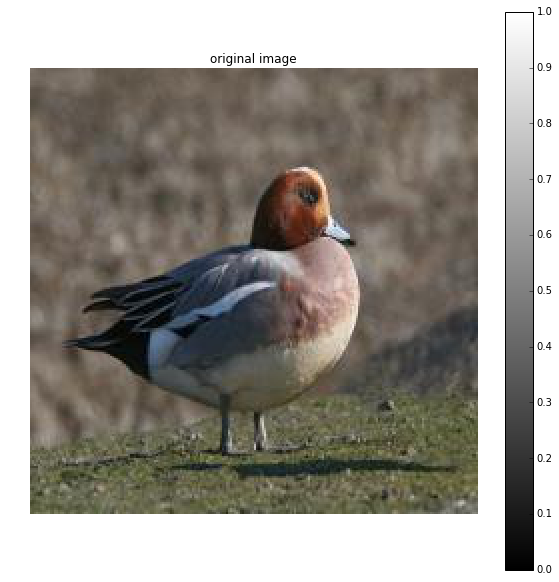

In [5]:
# BIRD
im = np.array(Image.open('../experiment_images/val/img331536.jpg')).astype(float) / 255
print "Bird shape:", im.shape
plt.title("original image")
plt.imshow(im)
plt.colorbar()
plt.axis('off')
im = im.transpose(2,0,1)
print "shape after transpose: ", im.shape
im_input = im[np.newaxis, :, :]

"""
# CAT
im = np.array(Image.open('../caffe/examples/images/cat_gray.jpg'))
im_input = im[np.newaxis, np.newaxis, :, :]
plt.title("original image")
plt.imshow(im)
plt.axis('off')
"""
print "input shape", im_input.shape, "input type", im_input.dtype

net.blobs['input_img'].reshape(*im_input.shape)
net.blobs['input_img'].data[...] = im_input

The convolution weights are initialized from Gaussian noise while the biases are initialized to zero. These random filters give output somewhat like edge detections.

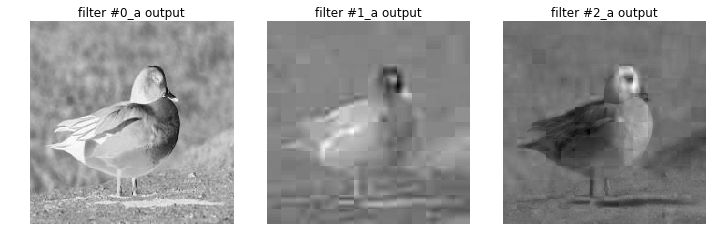

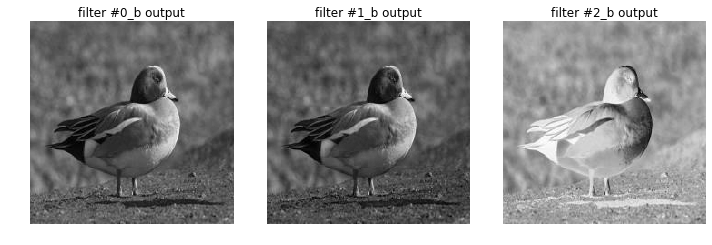

In [6]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure(1)
    #filt_min, filt_max = net.blobs['guess' + '_' + colordim].data.min(), net.blobs['guess' + '_' + colordim].data.max()
    #print filt_min, filt_max
    for i in range(3):
        plt.subplot(2,3,i+1)
        plt.title("filter #{}_a output".format(i))
        plt.imshow(net.blobs['guess_a'].data[0, i])#, vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')
    
    plt.figure(2)
    for i in range(3):
        plt.subplot(2,3,i+4)
        plt.title("filter #{}_b output".format(i))
        plt.imshow(net.blobs['guess_b'].data[0, i])#, vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

show_filters(net)

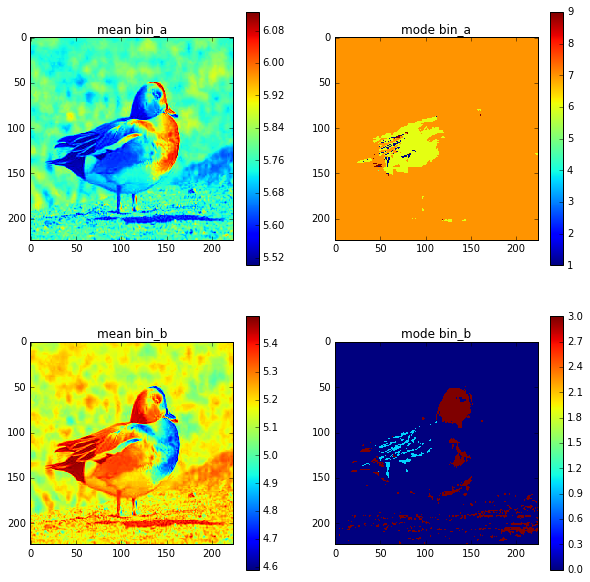

In [54]:
# Find most likely bins, by mode and mean
num_of_bins = net.blobs['guess_a'].data.shape[1]
mean_bin_a = np.zeros_like(net.blobs['Softmax_a'].data[0,:,:,:])
mean_bin_b = np.zeros_like(net.blobs['Softmax_a'].data[0,:,:,:])

# Values are probabilities, multiply by bin number and sum to get expected bin
for i in range(num_of_bins):
    mean_bin_a[i] = (i + 1) * net.blobs['Softmax_a'].data[0,i,:,:]
    mean_bin_b[i] = (i + 1) * net.blobs['Softmax_b'].data[0,i,:,:]
mean_bin_a = np.sum(mean_bin_a, axis=0)
mean_bin_b = np.sum(mean_bin_b, axis=0)

# Plot mean and mode of a and b
plt.subplot(221)
plt.imshow(mean_bin_a,cmap='jet')
plt.colorbar()
plt.title('mean bin_a')

plt.subplot(222)
plt.imshow(np.argmax(net.blobs['Softmax_a'].data, axis=1)[0,:,:],cmap='jet')
plt.colorbar()
plt.title('mode bin_a')

plt.subplot(223)
plt.imshow(mean_bin_b,cmap='jet')
plt.colorbar()
plt.title('mean bin_b')

plt.subplot(224)
plt.imshow(np.argmax(net.blobs['Softmax_b'].data, axis=1)[0,:,:],cmap='jet')
plt.colorbar()
plt.title('mode bin_b')

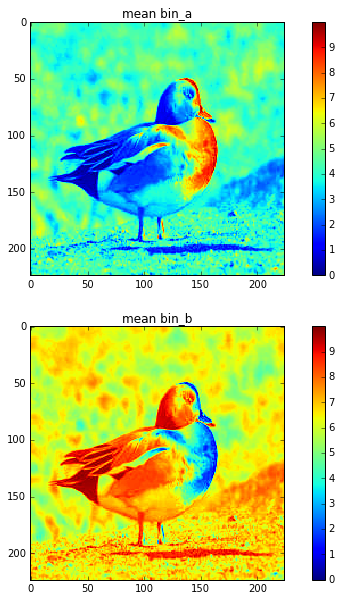

In [55]:
# Experiment with broaden the color range
broad_bin_a = (mean_bin_a - mean_bin_a.min()) / ( mean_bin_a.max() - mean_bin_a.min()) * (num_of_bins - 0.0001)
broad_bin_b = (mean_bin_b - mean_bin_b.min()) / ( mean_bin_b.max() - mean_bin_b.min()) * (num_of_bins - 0.0001)

plt.subplot(211)
plt.imshow(broad_bin_a,cmap='jet')
plt.colorbar()
plt.title('mean bin_a')

plt.subplot(212)
plt.imshow(broad_bin_b,cmap='jet')
plt.colorbar()
plt.title('mean bin_b')

mean_bin_a = broad_bin_a
mean_bin_b = broad_bin_b

a: -0.4999 0.490189
b: -0.4999 0.490189
a: -0.74381 0.4667
b: -0.74381 0.4667
a: 32.6642 187.004
b: 32.6642 187.004
l: 0.295012052589 98.1273747893


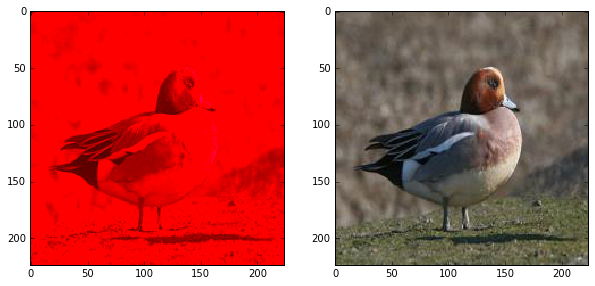

In [72]:
# Map bin to ab-color
sigma = 0.2 # Used in bell curve to map color to bin

# Adjust to the values the integral produces, i.e. range [-0.5, 0.5]
# visualize_bin_quantiles.ipynb demonstrates the mapping from color to bin
integral_a = mean_bin_a / (num_of_bins + 0.1) - 0.4999
integral_b = mean_bin_b / (num_of_bins + 0.1) - 0.4999

print 'a:', integral_a.min(), integral_a.max()
print 'b:', integral_b.min(), integral_b.max()

# Get the color on range [-1, 1]
a = erfinv(2 * integral_a) * np.sqrt(2) * sigma
b = erfinv(2 * integral_b) * np.sqrt(2) * sigma

print 'a:', a.min(), a.max()
print 'b:', b.min(), b.max()

# Map to from [-1, 1] to [0, 255]
a = (a + 1) * 255 / 2
b = (b + 1) * 255 / 2

print 'a:', a.min(), a.max()
print 'b:', b.min(), b.max()

print 'l:', real_l.min(), real_l.max()


real_lab = color.rgb2lab( np.transpose((im),(1,2,0)) )
real_l = real_lab[:,:,0]
real_rgb = color.lab2rgb( real_lab )

new_lab = np.stack((real_l, a, b), axis=2)
new_rgb = color.lab2rgb( new_lab )

plt.subplot(121)
plt.imshow(new_rgb)

plt.subplot(122)
plt.imshow(real_rgb)
#plt.imshow(np.transpose((im),(1,2,0)))






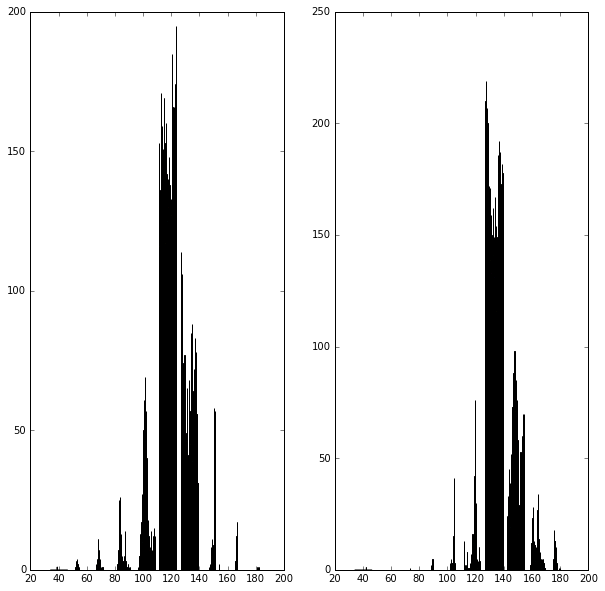

In [73]:
# Histograms takes some time to calculate
plt.subplot(121)
plt.hist(a)

plt.subplot(122)
plt.hist(b)
plt.show()